<a href="https://colab.research.google.com/github/dbtmddn41/deep_learning/blob/main/kaggle/cactus_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '딥러닝/kaggle/cactus\ identification'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/딥러닝/kaggle/cactus identification


In [2]:
!mkdir -p ~/.kaggle
!cp ../kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c aerial-cactus-identification

!unzip -o aerial-cactus-identification.zip
!unzip -qq -o train.zip
!unzip -qq -o test.zip

aerial-cactus-identification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  aerial-cactus-identification.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

# 데이터 둘러보기

In [5]:
labels = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
import os, shutil, pathlib
from sklearn.model_selection import train_test_split

if 'cactus_train' in os.listdir():
    shutil.rmtree('cactus_train/')
origin_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cactus_train")
def make_subset(subset_name, df):
    for i, category in enumerate(('hasnot', 'has')):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = df[df['has_cactus']==i]['id']
        for fname in fnames:
            shutil.copyfile(src=origin_dir/fname, dst=dir/fname)

train_data, validation_data = train_test_split(labels, test_size=0.1, random_state=42, stratify=labels['has_cactus'])
make_subset("train", train_data)
make_subset("validation", validation_data)

In [7]:
print(train_data.describe())
print(validation_data.describe())

         has_cactus
count  14000.000000
mean       0.750643
std        0.432656
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
        has_cactus
count  3500.000000
mean      0.750571
std       0.432744
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000


In [8]:
if 'cactus_test' in os.listdir():
    shutil.rmtree('cactus_test/')

os.mkdir('cactus_test/')
os.mkdir('cactus_test/test')
for fname in os.listdir('test/'):
    shutil.copyfile('test/' + fname, 'cactus_test/test/'+fname)

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir / 'train', image_size=(32, 32), batch_size=3500)
val_dataset = image_dataset_from_directory(new_base_dir / 'validation', image_size=(32, 32), batch_size=3500)
test_dataset = image_dataset_from_directory('cactus_test', image_size=(32, 32), batch_size=3500)


Found 14000 files belonging to 2 classes.
Found 3500 files belonging to 2 classes.
Found 4000 files belonging to 1 classes.


tf.Tensor([0 0 0 ... 0 0 0], shape=(3500,), dtype=int32)
tf.Tensor([0 0 1 ... 0 0 0], shape=(3500,), dtype=int32)
tf.Tensor([0 0 0 ... 0 0 0], shape=(3500,), dtype=int32)
tf.Tensor([1 0 1 ... 0 1 1], shape=(3500,), dtype=int32)
tf.Tensor([1 0 1 ... 0 0 1], shape=(3500,), dtype=int32)


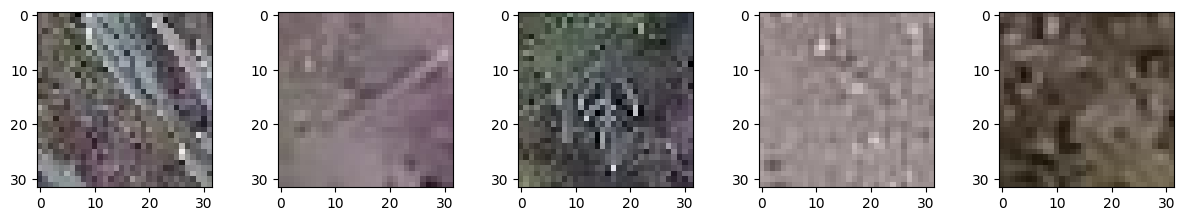

In [10]:
i=1
plt.figure(figsize=(15, 5))
for image, target in train_dataset.take(5):
    image = image[0].numpy().astype(np.uint8)
    ax = plt.subplot(2,5,i)
    ax.imshow(image)
    print(target)
    i+=1

for image, target in val_dataset.take(5):
    image = image[0].numpy().astype(np.uint8)
    ax = plt.subplot(2,5,i)
    ax.imshow(image)
    print(target)
    i+=1

In [28]:
from tensorflow import keras

base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3),
    pooling='avg',
    include_preprocessing=True
)

In [29]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 32, 32, 3)    0           ['input_7[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 32, 32, 3)   0           ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 16, 16, 32)   864         ['normalization_3

In [30]:
base_model.trainable = False

In [64]:
data_augment = keras.Sequential([
      layers.RandomFlip('horizontal_and_vertical'),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1)
])

inputs = keras.Input(shape=(32,32,3))
x = data_augment(inputs)
x = base_model(x)
x = layers.Dense(600, activation='elu')(x)
x = layers.Dense(300, activation='elu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [65]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=30,
    decay_rate=0.9)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]

history = model.fit(train_dataset.cache().prefetch(tf.data.AUTOTUNE), epochs=400, validation_data=val_dataset.cache().prefetch(tf.data.AUTOTUNE), callbacks=callbacks)

Epoch 1/400
4/4 [==============================] - 21s 2s/step - loss: 22.6721 - accuracy: 0.4253 - val_loss: 1.2154 - val_accuracy: 0.7506
Epoch 2/400
4/4 [==============================] - 1s 220ms/step - loss: 1.0923 - accuracy: 0.7506 - val_loss: 1.2703 - val_accuracy: 0.2494
Epoch 3/400
4/4 [==============================] - 1s 385ms/step - loss: 0.8578 - accuracy: 0.5004 - val_loss: 0.8645 - val_accuracy: 0.7506
Epoch 4/400
4/4 [==============================] - 1s 374ms/step - loss: 0.7043 - accuracy: 0.7507 - val_loss: 0.6291 - val_accuracy: 0.7506
Epoch 5/400
4/4 [==============================] - 1s 373ms/step - loss: 0.6132 - accuracy: 0.7446 - val_loss: 0.5448 - val_accuracy: 0.7506
Epoch 6/400
4/4 [==============================] - 1s 219ms/step - loss: 0.5678 - accuracy: 0.7506 - val_loss: 0.5603 - val_accuracy: 0.7506
Epoch 7/400
4/4 [==============================] - 1s 219ms/step - loss: 0.5435 - accuracy: 0.7507 - val_loss: 0.5483 - val_accuracy: 0.7506
Epoch 8/400
4/

In [66]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title("Training and Validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

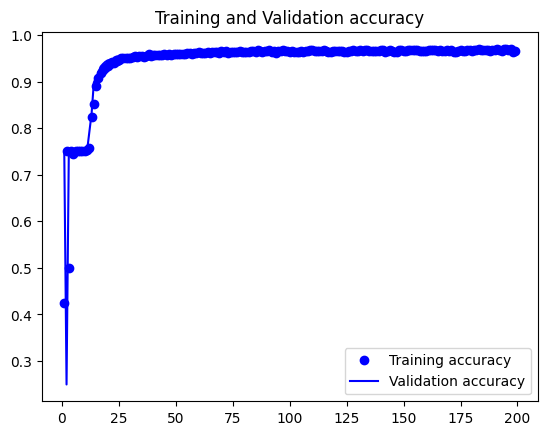

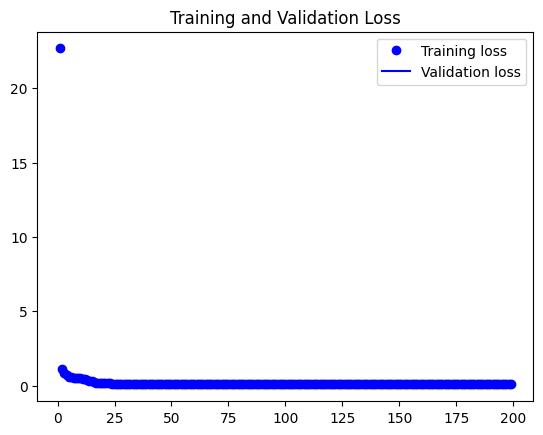

In [67]:
plot_history(history)

In [68]:
best_my_model = keras.models.load_model('best_model.keras')

best_my_model.evaluate(val_dataset)

1/1 [==============================] - 4s 4s/step - loss: 0.0827 - accuracy: 0.9709


[0.08269546926021576, 0.9708571434020996]

In [69]:
import cv2
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

validation_imgs = []
for img_name in tqdm(validation_data['id']):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    validation_imgs.append(image)

pred = best_my_model.predict(np.array(validation_imgs))
print(roc_auc_score(validation_data['has_cactus'], 1-pred))

100%|██████████| 3500/3500 [00:04<00:00, 805.08it/s]


110/110 [==============================] - 2s 8ms/step
0.9950492092208368
